# Определение возраста покупателей

## Описание проекта и данных.

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Описание данных.

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке `/datasets/faces/`. 
В вашем распоряжении одна папка со всеми изображениями `(/final_files)` и CSV-файл labels.csv с двумя колонками: 
- file_name 
- real_age. 

## Загрузка данных и библиотек.

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from tqdm import notebook
import os
import plotly.express as px
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
if os.path.exists('/datasets/faces/labels.csv'):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    display(labels.head())
else:
    print('Ошибка')

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Смотрим информацию о размере датафрейма.

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Данные загружены и соответствуют описанию.

## Исследовательский анализ данных

### Пропуски, дубликаты, аномалии.

Пропусков нет. Дубликатов тоже.

In [5]:
labels.duplicated().sum()

0

Посмотрим статистику по возрастам.

In [8]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


И рисуем гистограмму.

In [25]:
fig = px.histogram(labels['real_age'],title='Распределение людей по возрасту',labels={'value': 'Возраст'})\
.update_layout(yaxis_title="Число людей")
fig.update_layout(showlegend=False)
fig.show()

Видно что больше всего людей ~30 лет.  Так же есть пик вблизи нуля. 
Можно заметить, что пики есть при возрасте кратном 10 годам. Видимо это результат округления при заполнении.

Выведем на экран несколько фото с возрастом.

Found 7591 validated image filenames.


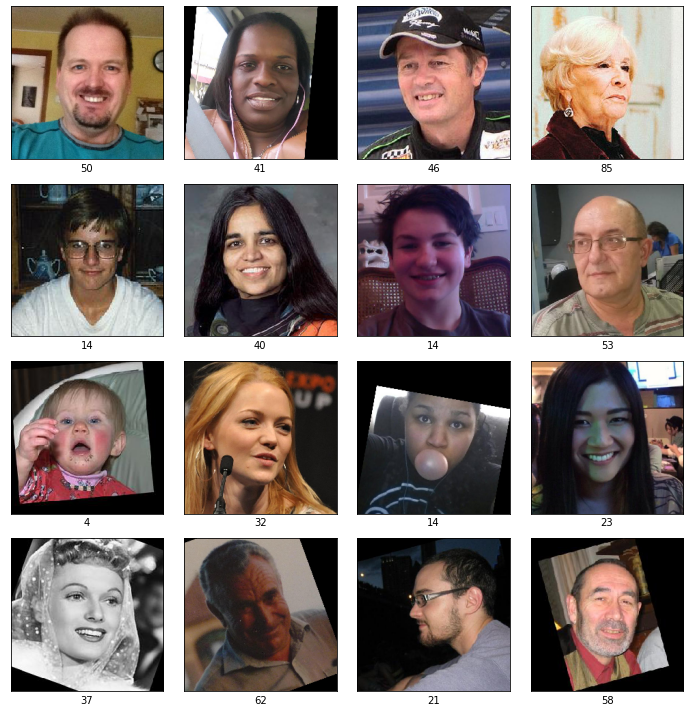

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 


features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xlabel(f'{target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Видно что присутствуют фото, где люди далеко и лица почти не видно при разрешении 224х224.  

Посмотрим так же на фото с максимальным и минимальным возрастом.

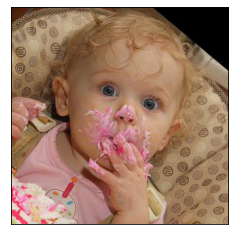

In [11]:
for i in labels.loc[labels['real_age']==1,'file_name'].head(1):
    image = Image.open(f'/datasets/faces/final_files/{i}')
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([]) 

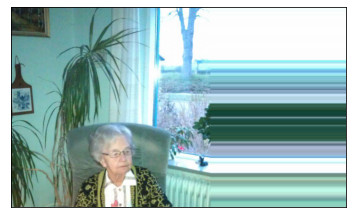

In [12]:
for i in labels.loc[labels['real_age']==100,'file_name'].head(1):
    image = Image.open(f'/datasets/faces/final_files/{i}')
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([]) 

На последнем фото можно заметить что форма не квадратная и с какими-то искажениями. Посмотрим есть ли еще не квадратные фотографии и что на них.

In [13]:
tqdm.pandas()
img_sizes = labels.copy()
img_sizes['size'] = img_sizes['file_name'].progress_apply(lambda x: 
                Image.open('/datasets/faces/final_files/'+x).size)

  0%|          | 0/7591 [00:00<?, ?it/s]

In [14]:
img_sizes['h'] = img_sizes['size'].str[0]
img_sizes['w'] = img_sizes['size'].str[1]
img_sizes['nsquare'] = abs(img_sizes['h'] - img_sizes['w'])>1
img_sizes['nsquare'].sum()

239

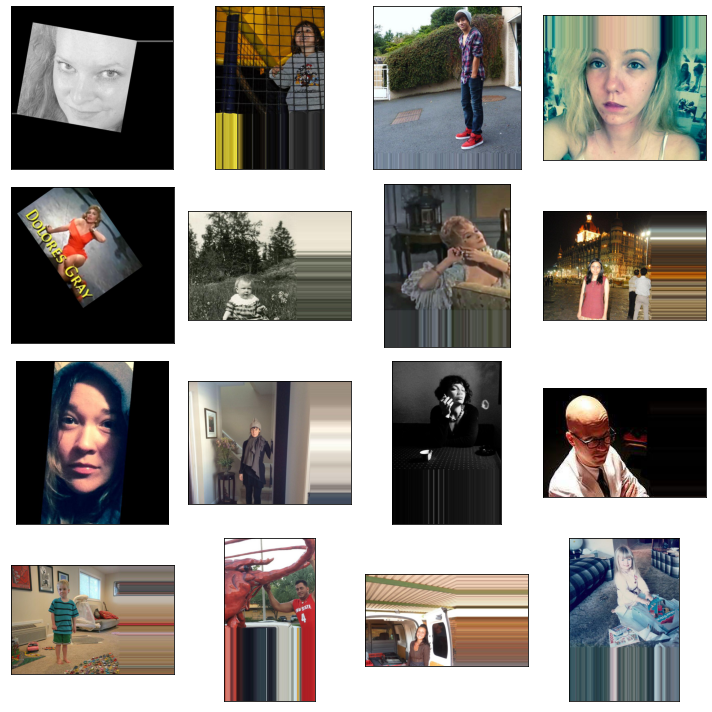

In [15]:
fig = plt.figure(figsize=(10,10))
i = 0
for name in img_sizes[img_sizes['nsquare']].sample(16)['file_name']:
    i = i+1
    fig.add_subplot(4, 4, i)
    image = Image.open(f'/datasets/faces/final_files/{name}')
    plt.imshow(image)
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Видно, что есть изображения с искажениями и совсем без людей на фото.

### Вывод

В данных нет ни дубликатов ни пропусков. Но есть несколько других проблем а именно.
- Дисбаланс классов. Людей старше 80 мало.
- Возраст не всегда реальный. (Пики при возрастах кратных 10. Вероятно округление.)
- Фото не всегда портретные.
- Есть фото с искажениями.
- Есть фото без людей.
- Есть фото с несколькими людьми.
- Есть черно-белые фото.

Вероятно проблемы с фото можно решить обучив отдельную модель, которая определяет портретные фото.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Постройте и обучите свёрточную нейронную сеть на датасете с фотографиями людей. Добейтесь значения MAE на тестовой выборке не больше 8.
Функцию загрузки тестовой выборки `load_test(path)` напишите самостоятельно. Вместе со старыми функциями в коде должны быть:
- `load_train(path)`,
- `load_test(path)`,
- `create_model(input_shape)`,
- `train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)`.

Выбранная модель представляет собой ResNet50 к которой добавлены lobalAveragePooling2D и один нейрон без активации для предсказания возраста. Обучаются только 2 последних слоя.

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import pandas as pd 


def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    labels = labels.loc[labels['real_age']%10!=0]

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123,
    )


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    labels = labels.loc[labels['real_age']%10!=0]

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123,
    )


def create_model(input_shape):
    
    backbone = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape, 
        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
    return model

```

###### Результат обучения

```

Train for 178 steps, validate for 60 steps
Epoch 1/15
178/178 - 52s - loss: 222.0684 - mean_absolute_error: 10.6863 - val_loss: 1065.5788 - val_mean_absolute_error: 27.8578
Epoch 2/15
178/178 - 43s - loss: 74.1302 - mean_absolute_error: 6.5149 - val_loss: 919.6521 - val_mean_absolute_error: 25.3392
Epoch 3/15
178/178 - 43s - loss: 46.2043 - mean_absolute_error: 5.1811 - val_loss: 419.0403 - val_mean_absolute_error: 15.3430
Epoch 4/15
178/178 - 43s - loss: 33.1495 - mean_absolute_error: 4.3884 - val_loss: 165.0519 - val_mean_absolute_error: 9.3979
Epoch 5/15
178/178 - 43s - loss: 26.1947 - mean_absolute_error: 3.8716 - val_loss: 79.9478 - val_mean_absolute_error: 6.7937
Epoch 6/15
178/178 - 43s - loss: 24.3653 - mean_absolute_error: 3.7606 - val_loss: 84.6565 - val_mean_absolute_error: 7.1638
Epoch 7/15
178/178 - 43s - loss: 18.9132 - mean_absolute_error: 3.3192 - val_loss: 68.2155 - val_mean_absolute_error: 6.0616
Epoch 8/15
178/178 - 43s - loss: 14.8868 - mean_absolute_error: 2.9566 - val_loss: 83.3132 - val_mean_absolute_error: 6.8816
Epoch 9/15
178/178 - 42s - loss: 11.9729 - mean_absolute_error: 2.6336 - val_loss: 69.0421 - val_mean_absolute_error: 6.2753
Epoch 10/15
178/178 - 43s - loss: 10.4972 - mean_absolute_error: 2.4309 - val_loss: 63.7671 - val_mean_absolute_error: 5.9682
Epoch 11/15
178/178 - 43s - loss: 9.1063 - mean_absolute_error: 2.3018 - val_loss: 63.8009 - val_mean_absolute_error: 5.9085
Epoch 12/15
178/178 - 43s - loss: 8.2120 - mean_absolute_error: 2.1591 - val_loss: 63.2466 - val_mean_absolute_error: 6.0603
Epoch 13/15
178/178 - 43s - loss: 7.5354 - mean_absolute_error: 2.0760 - val_loss: 67.5426 - val_mean_absolute_error: 6.1904
Epoch 14/15
178/178 - 43s - loss: 7.2132 - mean_absolute_error: 2.0148 - val_loss: 67.7732 - val_mean_absolute_error: 6.0615
Epoch 15/15
178/178 - 42s - loss: 6.7907 - mean_absolute_error: 1.9646 - val_loss: 64.7486 - val_mean_absolute_error: 5.8748

60/60 - 10s - loss: 64.7486 - mean_absolute_error: 5.8748
Test MAE: 5.8748

```

## Анализ обученной модели

Метрика которая была достигнута моделью MAE = 5.8748 за 15 эпох обучения. Что подходит под требования заказчика MAE<8. 
Из результатов обучения видно, что модель переобучилась. На тренировочной выборке метрика гораздо лучше, чем на тестовой.

Для более предметного анализа пригодился бы график остатков. Но ввиду специфики задания, построить не представляется возможным.

Достигнутая точность вполне может позволить выполнить первую задачу:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.
А вот контролировать добросовестность кассиров при продаже алкоголя точности уже не достаточно, т.к. условно модель будет допускать продажу алкоголя 13 летним и запрещать 23 летним.

Возиожные улучшения модели и процесса обучения. 
- Обучить отдельную модель которая выберет только портретные фото.
- Усилить контроль за правильностью заполнения возраста.
- Обьединить пожилых людей (>70 лет) в одну группу.
- Убрать из данных детей до 3 лет. (Врядли они покупают алкоголь или еще что-то.)